In [8]:
%reset -f
import time
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
import scipy.integrate as integrate
import scipy.interpolate as interpolate
from scipy.integrate import solve_bvp

# from tueplots.bundles import probnum2025
# plt.rcParams.update(probnum2025())


### 0. Solutions to the TOV-Equations and Source/Matter Terms

In [9]:
# Load the variables from tov-final
r_o   = 1.0e+3          # outer radius (maximum radius)
r_c   = 1.0e-1          # central radius (minimum radius)
P_c   = 1.0e-1          # central pressure (maximal pressure)

# Note: the value for the central pressure must be sufficiently low as to avoid having to deal with singularities (visible in alpha, psi)

# Specify and load the file
filename    = f'../data/tov_{round(np.log10(r_o)):+}{round(np.log10(r_c)):+}{round(np.log10(P_c)):+}.npy'
loaded_data = np.load(filename)

# Unpack the values
r, m, P, rho, R, alpha, psi = loaded_data

# Define polytropic constants (using c = G = 1 units for simplicity)
K     = 100    # Polytropic constant
Gamma = 2      # Polytropic exponent

# Polytropic Equation of State (EOS)
def pressure(rho):
    return K * rho**Gamma

downsample_factor = 2000
m     = m[::downsample_factor]
P     = P[::downsample_factor]
rho   = rho[::downsample_factor]
R     = R[::downsample_factor]
alpha = alpha[::downsample_factor]
psi   = psi[::downsample_factor]

# Express the source/matter terms
W  = 1                                         # Lorentz factor
v  = np.zeros_like(rho)                        # radial velocity

E  = rho
Sr = rho * (1 + P/rho) * W**2 * v
S  = rho * (1 + P/rho) * W**2 * v**2 + 3 * P


## 1. Application of a perturbation to the density

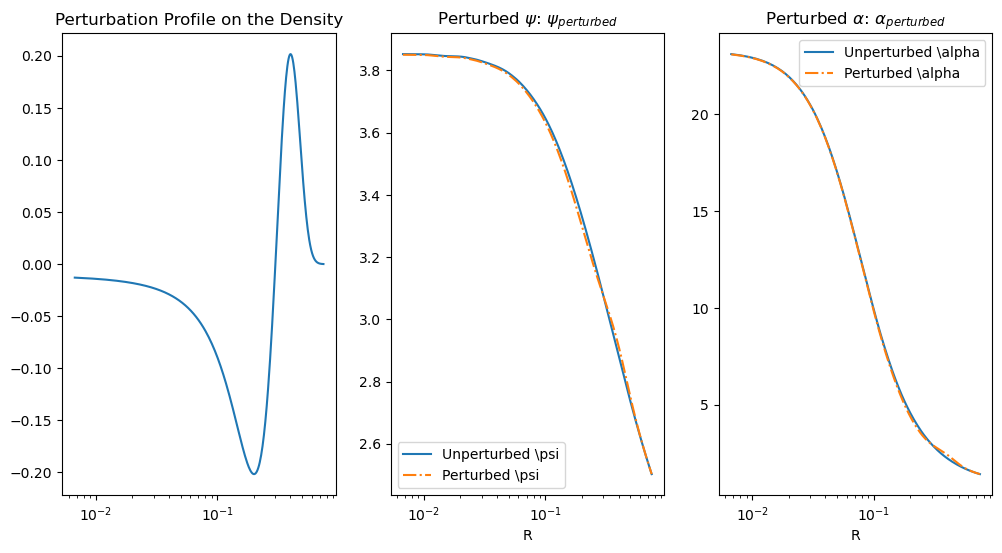

In [24]:
# Perturbation parameters
center_value  = 0.3        # Center value
sigma         = 1.0e-1     # Width of the full Gaussian
amplitude     = 1.0        # Scale factor

# Center Gaussian
center_index  = np.argmin(np.abs(R - center_value))
R_centered    = (R - R[center_index])/R[center_index]
gaussian      = amplitude * np.exp(-((R - R[center_index]) ** 2) / (2 * sigma**2))

# Multiplication of Gaussian with shifted R-axis
perturbation  = gaussian * R_centered

# Perturbation
scale_factor = 25
psi_perturbed   = psi + perturbation * np.max(psi) / scale_factor
alpha_perturbed = alpha + perturbation * np.max(alpha) / scale_factor

# Visualization
fig, ax = plt.subplots(1, 3, figsize=(12, 6))
ax[0].plot(R, perturbation)
ax[0].set_xscale('log')
ax[0].set_title("Perturbation Profile on the Density")

ax[1].plot(R, psi, label=r"Unperturbed \psi");
ax[1].plot(R, psi_perturbed, linestyle='-.', label=r"Perturbed \psi");
ax[1].set_xlabel('R');
ax[1].set_xscale('log');
ax[1].set_title(r"Perturbed $\psi$: $\psi_{perturbed}$");
ax[1].legend();

ax[2].plot(R, alpha, label=r"Unperturbed \alpha");
ax[2].plot(R, alpha_perturbed, linestyle='-.', label=r"Perturbed \alpha");
ax[2].set_xlabel('R');
ax[2].set_xscale('log');
ax[2].set_title(r"Perturbed $\alpha$: $\alpha_{perturbed}$");
ax[2].legend();



### 2. Problem Definition

In [27]:
# Apply the density perturbation of the source/matter terms
E_perturbed  = rho
Sr_perturbed = rho * (1 + P/rho) * W**2 * v
S_perturbed  = rho * (1 + pressure(rho)/rho) * W**2 * v**2 + 3 * pressure(rho)


Given the perturbation on the density, the vector equations are trivially zero.

We focus on the the first scalar ODE to solve is:

\begin{equation}
\left(\nabla^{2} + S_{1} / \psi^{2} + 7 S_{7} / \psi^{8} \right) \delta \psi = \delta S_{1} / \psi + \delta S_{7} / \psi^{7}
\end{equation}
in which 
\begin{align}
    S_1   &= -2 \pi \rho \\ 
    \delta S_1 &= - 2 \pi \rho \\
    S_7   &= 0 \\
    \delta S_7 &= 0
\end{align}

We can define $\tilde{k}^{2}_{\psi} = -S_{1} /  \psi^{2} - 7 S_{7} / \psi^{8}$ such that the scalar ODE becomes:
\begin{equation}
    \left(\nabla^{2} - \tilde{k}^{2}_{\psi} \right) \ \delta \psi = \delta S_{1} / \psi + \delta S_{7} / \psi^{7}
\end{equation}
Only considering nonzero functions and defining $k^2_{\psi} = - S_{1} / \psi^{2}$ yields:
\begin{equation}
    \left(\nabla^{2} - k^{2}_{\psi} \right) \ \delta \psi = \delta S_{1} / \psi
\end{equation}
The boundary conditions are:
\begin{align}
    \frac{d \delta \psi}{dr}(0) &= 0 \\
    \delta \psi(R) &= 0
\end{align}

In [28]:
# Upper bound of the integration domain
R_max = np.max(R)

# Definition of S1, k_squared
S1           = - 2*np.pi*rho
k_squared1   = - S1/psi**(2)

# Definition of source term
dS1          = -2*np.pi*np.zeros_like(perturbation)
source_term1 = dS1/psi


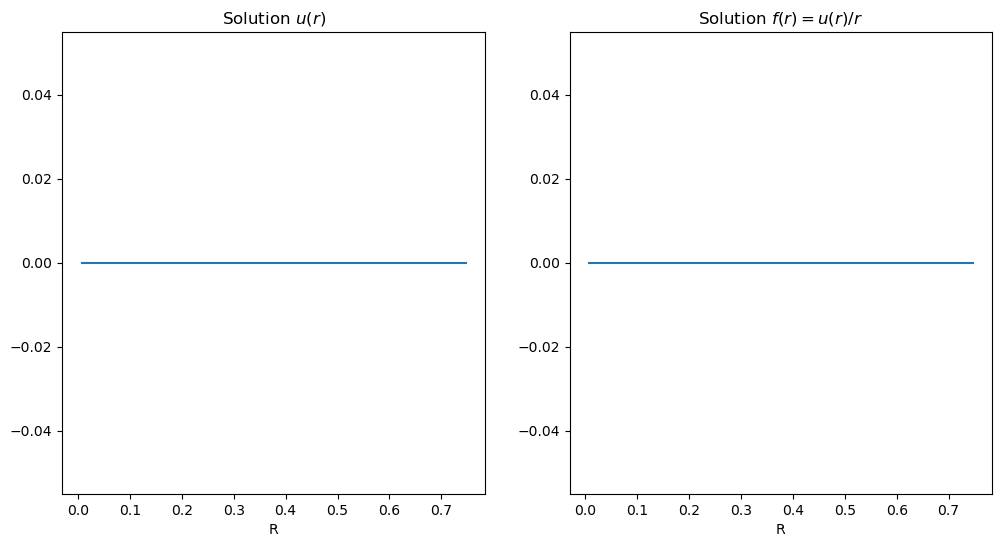

In [29]:
# Interpolate the numerically determined functions
k_squared1_interp   = interpolate.interp1d(R, k_squared1,   kind='cubic', bounds_error=False, fill_value='extrapolate')
source_term1_interp = interpolate.interp1d(R, source_term1, kind='cubic', bounds_error=False, fill_value='extrapolate')

# Conversion of the 2nd order ODE to a 1st order system of ODEs defining a state vector y such that y[0] = u, and y[1] = du/dr
def fun(r, y):
    u   = y[0]
    du  = y[1]
    ddu = k_squared1_interp(r) * u + r * source_term1_interp(r)
    return np.vstack((du, ddu))

# Define the boundary conditions:
def bc(ya, yb):
    r0 = r_domain[0]  # first grid point, e.g. 0.005
    return np.array([ya[0] - r0 * ya[1],  # inner BC: u(r0) - r0*u'(r0)=0
                     yb[0]             ])  # outer BC: u(R) = 0

# Define the domain
r_domain = R

# Initial guess for solution y: two components, u and du/dr
y_guess  = np.zeros((2, r_domain.size))

# Solve BVP
sol = solve_bvp(fun, bc, r_domain, y_guess)

# Recover f(r) = u(r)/r
u = sol.y[0]
f = u / r_domain

# Plotting
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].plot(R, u)
ax[0].set_xlabel('R');
ax[0].set_title(r"Solution $u(r)$")

ax[1].plot(R, f);
ax[1].set_xlabel('R');
ax[1].set_title(r"Solution $f(r) = u(r)/r$");
